# AEFIT

This would be the first attempt to run the unsupervised learning VAE network to learn how to characterize a 1D profile with atted noise and missing input.

More than a simple fit, this method should learn 

In [6]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt

import Dummy_g1data as dummy
import models.AEFIT as aefit

# ipysh.Bootstrap_support.debug()

## Data and Model
The model and data generator are set:
Dummy data generator generates from a set of 5 kind of curves with a dataset cardinality of 60K samples.

All the shapes are generated from a dictionary array that defines mean sigma and gain of sum of gaussians.
This table is printed from the variable ds.kinds

>NOTE: 
> The actual model is generating random so it is not redoing the very same samples on each epoch.
> To exactly constraint the maximum size of the dataset the tf buffer can be used

the model uses bby default an input of 40 samples that are the (x,y) tuple values of 20 points from the generated shapes.


In [11]:
ds = dummy.Dummy_g1data(counts=60000)
m = aefit.AEFIT(latent_dim=2)

ds.kinds

[{'gain': [1, 1], 'mean': [0.2, 0.8], 'sigma': [0.1, 0.1]},
 {'gain': [0.5], 'mean': [0.8], 'sigma': [0.1]},
 {'gain': [0.5], 'mean': [0.2], 'sigma': [0.1]},
 {'gain': [1], 'mean': [0.5], 'sigma': [0.2]},
 {'gain': [0.5], 'mean': [0.5], 'sigma': [0.2]}]

0-20 loss: 23.747568
0-40 loss: 22.761108
0-60 loss: 22.437279
0-80 loss: 22.385977
0-100 loss: 22.023260
0-120 loss: 22.281921
0-140 loss: 21.926332
0-160 loss: 21.770903
0-180 loss: 21.858437
0-200 loss: 21.886162
0-220 loss: 21.689289
0-240 loss: 21.995581
0-260 loss: 21.557867
0-280 loss: 21.948008
0-300 loss: 21.875229
1-320 loss: 21.646862
1-340 loss: 21.670059
1-360 loss: 21.928455
1-380 loss: 21.840294
1-400 loss: 21.594654
1-420 loss: 21.363697
1-440 loss: 20.950327
1-460 loss: 21.333786
1-480 loss: 21.230328
1-500 loss: 21.519136
1-520 loss: 21.549927
1-540 loss: 21.410650
1-560 loss: 21.424017
1-580 loss: 21.418196
1-600 loss: 21.400860
2-620 loss: 21.443645
2-640 loss: 21.360126
2-660 loss: 21.067026
2-680 loss: 21.541553
2-700 loss: 21.055080
2-720 loss: 21.562271
2-740 loss: 21.442177
2-760 loss: 21.287647
2-780 loss: 21.353350
2-800 loss: 21.325336
2-820 loss: 21.308949
2-840 loss: 21.182745
2-860 loss: 21.160774
2-880 loss: 21.064951
2-900 loss: 21.061918
3-920 loss: 21

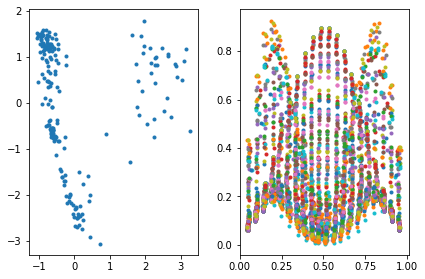

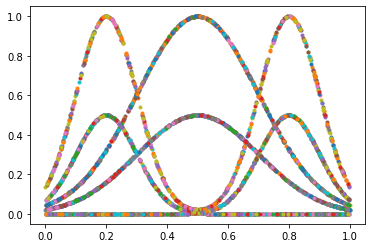

In [12]:
aefit.test_dummy(m, data=ds, epoch=5, batch=200, loss_factor=1e-3)

In [ ]:
# m.save('kcp/aefit1')

In [ ]:
!pwd

In [1]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hplt.LSPlotBokeh()
p.set_model(m)
p.set_data(ds)
p.plot(notebook_url='http://172.17.0.2:8888')

Loading BokehJS ...

NameError: name 'Hplt' is not defined

## Missing data simulation

Now we want to test the network against particular shapes within the latent main paths but with added noise and simulated missing data. The function simulate_missing_data reduce de number of available input simply duplicating the point that precedes the missing one with the same value.

A further gaussian noise has been also applied.

In [14]:

def simulate_missing_data(lpt=[0.5,-1.6], noise_var=0.05, arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]):
    xy = m.decode(tf.convert_to_tensor([pt]),apply_sigmoid=True)
    x,y = tf.split(xy[0], 2)
    x,y = (x.numpy(), y.numpy())

    fig = plt.figure('gen_missing_curve',figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)    
    
    ax1.set_xlim(-2.,2.)
    ax1.set_ylim(-2.,2.)
    
    ax1.scatter(pt[0],pt[1],s=80)
    ax2.scatter(x,y,s=40)

    # apply noise
    x += np.random.normal(0,noise_var,len(x))
    y += np.random.normal(0,noise_var,len(y))

    # apply missing data simulation
    for i,v in enumerate(arr,0):
        x[arr[i]]=x[arr[i]+1]
        y[arr[i]]=y[arr[i]+1]
    
    ax2.scatter(x,y,s=80)

    me,va = m.encode(tf.reshape(tf.concat([x,y],0), shape=[1,-1]))
    print("Guessed Latent point = ",me.numpy())
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = m.decode(me,apply_sigmoid=True)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    # plt.figure('reconstructed')
    ax2.scatter(X,Y,s=40)
    # plt.plot(X,Y)



We start by generating close to the shape {'mean': [0.5], 'sigma': [0.2], 'gain': [0.5]}

This is in the middle of the central cluster

Guessed Latent point =  [[-0.23062113 -0.53997093]]


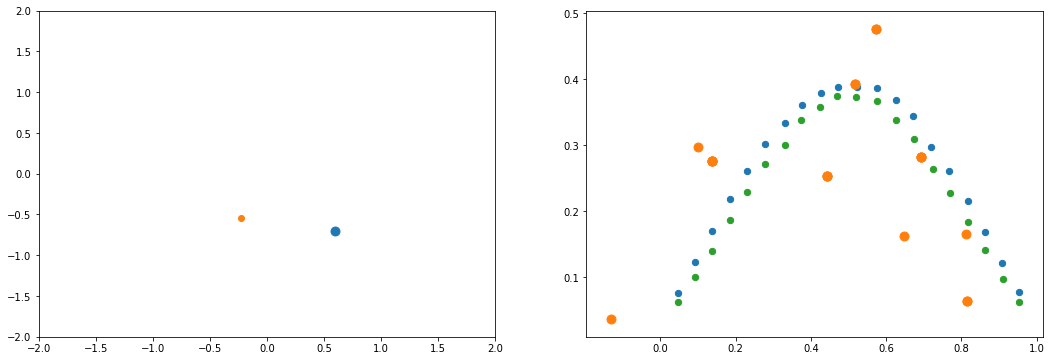

In [15]:

    
# generate from point: 0.6, -0.7
pt = [0.6,-0.7]
noise_var = 0.1
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(pt,noise_var,arr)


Now we want to check if the nework can simulate a point in the middle od two clusters

Guessed Latent point =  [[-0.03967327 -1.89299   ]]


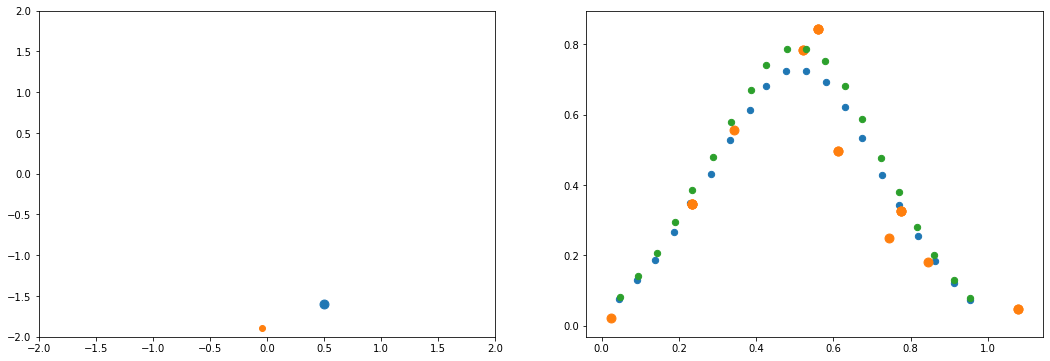

In [16]:
# generate from point: 0.5, -1.6
pt = [0.5,-1.6]
noise_var = 0.05
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(pt,noise_var,arr)

